<a href="https://colab.research.google.com/github/jamesaycheese/MSDS_453_A1/blob/main/Assignment_2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import os
import re
import string
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
# !pip install bertopic
from bertopic import BERTopic
from typing import List, Dict
from dataclasses import dataclass
from IPython.display import display
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
import nltk

from gensim import corpora, similarities
from gensim.models import (
    Word2Vec, LdaModel, LsiModel, CoherenceModel, TfidfModel
)

from transformers import (
    pipeline, AutoTokenizer, AutoModelForSequenceClassification,TFAutoModelForSequenceClassification,DistilBertTokenizer,TFDistilBertForSequenceClassification
)

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,ENGLISH_STOP_WORDS
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score,
    confusion_matrix, accuracy_score, f1_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

# Ensure NLTK stopwords are downloaded
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

@dataclass
class Document:
    doc_id: str
    text: str

def get_corpus_df(path):
    data = pd.read_csv(path, encoding="utf-8")
    data['Descriptor'] = data['Genre of Movie'] + '_' + data['Movie Title'] + '_' + data['Review Type (pos or neg)'].apply(lambda x: 'P' if x == 'Positive' else 'N') + '_' + data['Doc_ID'].astype(str)
    sorted_data = data.sort_values(['Descriptor']).set_index(['Doc_ID'])
    return sorted_data

def clean_doc(doc):
    tokens = re.sub(f"[{string.punctuation}]", "", doc).lower().split()
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if len(w) > 4 and w.isalpha() and w not in stop_words]
    return tokens

def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range=(1,1))
    TFIDF_matrix=Tfidf.fit_transform(corpus)
    words = Tfidf.get_feature_names_out() # For sklearn >= 1.0.x
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names_out(), index=titles)
    return matrix #,words

def k_means(titles, tfidf_matrix, k=3):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    clusters = kmeans.labels_.tolist()
    cluster_frame = pd.DataFrame({'Doc Name': titles, 'Cluster': clusters})
    cluster_title = cluster_frame.groupby('Cluster')['Doc Name'].apply(list).to_dict()
    print("Cluster Titles:", cluster_title)
    return cluster_title, clusters, cluster_frame

def plot_clusters(matrix, labels, method_name=""):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(matrix)
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, palette="viridis", s=60)
    plt.title(f"{method_name} Clustering Visualization with t-SNE")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend(title="Cluster")
    plt.show()
def warn(*args, **kwargs):
    pass
    warnings.warn = warn

# Ensure NLTK stopwords are downloaded
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

In [89]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/barrycforever/MSDS_453_NLP/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec56_v1_20241003.csv'
data = get_corpus_df(CORPUS_PATH)

data = get_corpus_df(CORPUS_PATH)
data['processed_text'] = data['Text'].apply(clean_doc)
final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
titles = data['Descriptor'].tolist()


In [90]:
raw_text = [text.strip().lower() for text in data['Text']]

raw_text[:1]

import re

def clean_non_ascii(text):
    # Replace common non-ASCII characters with their ASCII equivalents
    text = text.replace('\x93', '"').replace('\x94', '"')  # Smart double quotes
    text = text.replace('\x91', "'").replace('\x92', "'")  # Smart single quotes
    text = text.replace('\x96', '-').replace('\x97', '-')  # Long dashes

    # Remove any remaining non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    return text

raw_text_cleaned = [clean_non_ascii(text) for text in raw_text]
raw_text_cleaned[:1]

data['final_processed_text'] = final_processed_text

data['raw_text'] = raw_text

labels = data['Review Type (pos or neg)'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'negative' else 1)


Processing final_processed_text...
Evaluating TF-IDF for final_processed_text
TF-IDF - final_processed_text | K=2, Inertia=187.28, Silhouette Score=0.012, Calinski-Harabasz Score=3.52
TF-IDF - final_processed_text | K=3, Inertia=184.29, Silhouette Score=0.017, Calinski-Harabasz Score=3.37
TF-IDF - final_processed_text | K=4, Inertia=181.61, Silhouette Score=0.020, Calinski-Harabasz Score=3.24
TF-IDF - final_processed_text | K=5, Inertia=179.19, Silhouette Score=0.023, Calinski-Harabasz Score=3.10
TF-IDF - final_processed_text | K=6, Inertia=174.27, Silhouette Score=0.037, Calinski-Harabasz Score=3.64
TF-IDF - final_processed_text | K=7, Inertia=172.73, Silhouette Score=0.034, Calinski-Harabasz Score=3.33
TF-IDF - final_processed_text | K=8, Inertia=169.20, Silhouette Score=0.044, Calinski-Harabasz Score=3.47
TF-IDF - final_processed_text | K=9, Inertia=167.57, Silhouette Score=0.044, Calinski-Harabasz Score=3.28
TF-IDF - final_processed_text | K=10, Inertia=165.07, Silhouette Score=0.

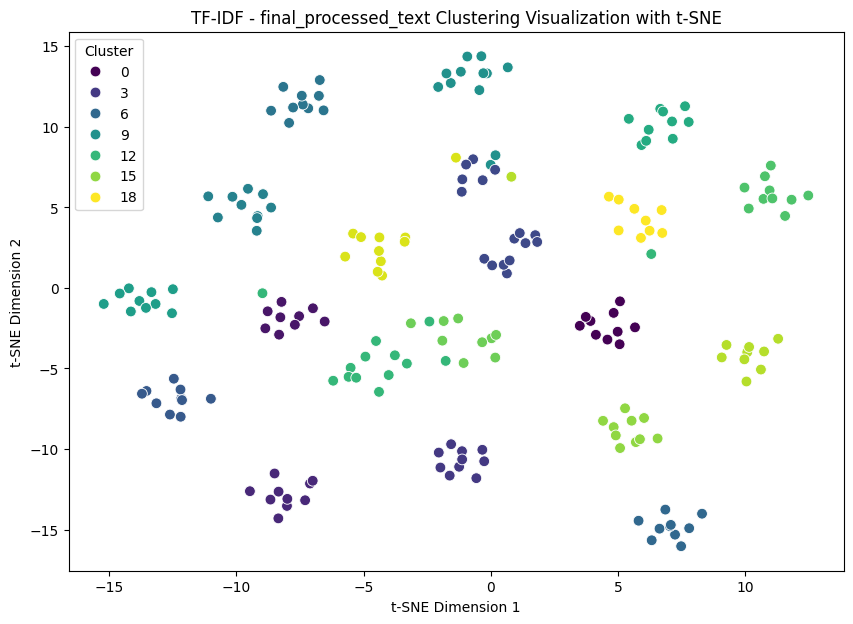

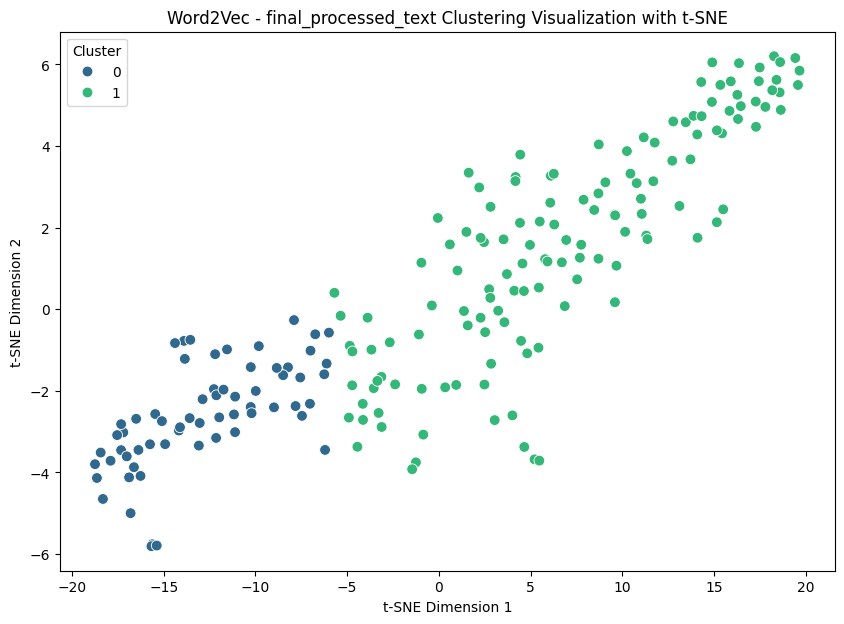

In [93]:
texts_variants = {
    "final_processed_text": final_processed_text
}

# Loop over each text variant
for name, texts in texts_variants.items():
    print(f"\nProcessing {name}...")

    # Define TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(texts).toarray()  # Convert to dense array

    # Train Word2Vec Model on all texts for Word2Vec embedding
    w2v_model = Word2Vec(sentences=[text.split() for text in texts], vector_size=100, window=5, min_count=1, sg=1)
    word2vec_vectors = []
    for text in texts:
        words = text.split()
        vector = np.mean([w2v_model.wv[word] for word in words if word in w2v_model.wv], axis=0)
        word2vec_vectors.append(vector)
    word2vec_matrix = np.array(word2vec_vectors)
    word2vec_matrix = StandardScaler().fit_transform(word2vec_matrix)

    # Define range of k values
    k_values = range(2, 21)

    def evaluate_clustering(matrix, method_name):
        """Perform clustering on a given matrix and evaluate with KMeans for each k in k_values."""
        results = []

        for k in k_values:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(matrix)

            # Calculate metrics
            inertia = kmeans.inertia_
            silhouette = silhouette_score(matrix, kmeans.labels_)
            ch_score = calinski_harabasz_score(matrix, kmeans.labels_)

            results.append((k, inertia, silhouette, ch_score))
            print(f"{method_name} | K={k}, Inertia={inertia:.2f}, Silhouette Score={silhouette:.3f}, Calinski-Harabasz Score={ch_score:.2f}")

        return pd.DataFrame(results, columns=['K', 'Inertia', 'Silhouette', 'Calinski-Harabasz'])

    # Evaluate and store results for both TF-IDF and Word2Vec
    print(f"Evaluating TF-IDF for {name}")
    tfidf_results = evaluate_clustering(tfidf_matrix, f"TF-IDF - {name}")

    print(f"\nEvaluating Word2Vec for {name}")
    word2vec_results = evaluate_clustering(word2vec_matrix, f"Word2Vec - {name}")

    # Choose the best k based on highest silhouette score for both methods
    best_k_tfidf = tfidf_results.loc[tfidf_results['Silhouette'].idxmax(), 'K']
    best_k_word2vec = word2vec_results.loc[word2vec_results['Silhouette'].idxmax(), 'K']
    print(f"\nBest k for TF-IDF ({name}): {best_k_tfidf}")
    print(f"Best k for Word2Vec ({name}): {best_k_word2vec}")

    # Visualize clusters using t-SNE for both TF-IDF and Word2Vec
    def plot_clusters(matrix, labels, method_name):
        tsne = TSNE(n_components=2, random_state=42)
        tsne_results = tsne.fit_transform(matrix)

        plt.figure(figsize=(10, 7))
        sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, palette="viridis", s=60)
        plt.title(f"{method_name} Clustering Visualization with t-SNE")
        plt.xlabel("t-SNE Dimension 1")
        plt.ylabel("t-SNE Dimension 2")
        plt.legend(title="Cluster")
        plt.show()

    # Clustering with optimal k and plotting for TF-IDF
    kmeans_tfidf = KMeans(n_clusters=best_k_tfidf, random_state=42)
    tfidf_labels = kmeans_tfidf.fit_predict(tfidf_matrix)
    plot_clusters(tfidf_matrix, tfidf_labels, f"TF-IDF - {name}")

    # Clustering with optimal k and plotting for Word2Vec
    kmeans_word2vec = KMeans(n_clusters=best_k_word2vec, random_state=42)
    word2vec_labels = kmeans_word2vec.fit_predict(word2vec_matrix)
    plot_clusters(word2vec_matrix, word2vec_labels, f"Word2Vec - {name}")

In [94]:
# Use the best k found from Word2Vec (k=2)
best_k = 2  # Or change to 2 if you want to use Word2Vec clusters

# Run K-means again with the best k value
cluster_title, clusters, k_means_df = k_means(titles, tfidf_matrix, k=best_k)



Cluster Titles: {0: ['Action_Kingsman__The_Secret_Service_N_166', 'Action_Kingsman__The_Secret_Service_N_167', 'Action_Kingsman__The_Secret_Service_N_168', 'Action_Kingsman__The_Secret_Service_N_169', 'Action_Kingsman__The_Secret_Service_N_170', 'Action_Kingsman__The_Secret_Service_P_161', 'Action_Kingsman__The_Secret_Service_P_162', 'Action_Kingsman__The_Secret_Service_P_163', 'Action_Kingsman__The_Secret_Service_P_164', 'Action_Kingsman__The_Secret_Service_P_165', 'Action_No_Time_to_Die_N_229', 'Action_Top_Gun_N_256', 'Action_Top_Gun_N_257', 'Action_Top_Gun_N_258', 'Action_Top_Gun_N_259', 'Action_Top_Gun_N_260', 'Action_Top_Gun_P_251', 'Action_Top_Gun_P_252', 'Action_Top_Gun_P_253', 'Action_Top_Gun_P_254', 'Action_Top_Gun_P_255', 'Comedy_Barbie_N_116', 'Comedy_Barbie_N_117', 'Comedy_Barbie_N_118', 'Comedy_Barbie_N_119', 'Comedy_Barbie_N_120', 'Comedy_Barbie_P_111', 'Comedy_Barbie_P_112', 'Comedy_Barbie_P_113', 'Comedy_Barbie_P_114', 'Comedy_Barbie_P_115', 'Comedy_Lost_City_N_212', 'C

In [95]:
##part 2

In [96]:
#Part 2a


# List of text versions to test
text_versions = {
    "Final Processed Text": final_processed_text
}

# Labels (positive = 1, negative = 0)
y = labels

# Different vectorization methods
vectorizers = {
    "TF-IDF": TfidfVectorizer()
}

# Different classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": MultinomialNB(),
    "KNN": KNeighborsClassifier()
}

# Loop through each text version
for text_name, X in text_versions.items():
    print(f"Evaluating Text Version: {text_name}")

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # Loop through each vectorizer and classifier combination
    for vec_name, vectorizer in vectorizers.items():
        # Vectorize the training and test data
        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)

        for clf_name, clf in classifiers.items():
            print(f"\nEvaluating {vec_name} + {clf_name} for {text_name}")

            # Train the classifier
            clf.fit(X_train_vec, y_train)

            # Make predictions
            y_pred = clf.predict(X_test_vec)

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            cm = confusion_matrix(y_test, y_pred)

            print(f"Accuracy: {accuracy:.4f}")
            print(f"F1-Score: {f1:.4f}")
            print("Confusion Matrix:")
            print(cm)
            print("-" * 50)

print("Experiment completed for all text versions, vectorizers, and classifiers.")

Evaluating Text Version: Final Processed Text

Evaluating TF-IDF + Logistic Regression for Final Processed Text
Accuracy: 0.3500
F1-Score: 0.3158
Confusion Matrix:
[[ 4  2]
 [11  3]]
--------------------------------------------------

Evaluating TF-IDF + SVM for Final Processed Text
Accuracy: 0.3500
F1-Score: 0.1333
Confusion Matrix:
[[ 6  0]
 [13  1]]
--------------------------------------------------

Evaluating TF-IDF + Random Forest for Final Processed Text
Accuracy: 0.5000
F1-Score: 0.5833
Confusion Matrix:
[[3 3]
 [7 7]]
--------------------------------------------------

Evaluating TF-IDF + Naive Bayes for Final Processed Text
Accuracy: 0.4000
F1-Score: 0.4000
Confusion Matrix:
[[ 4  2]
 [10  4]]
--------------------------------------------------

Evaluating TF-IDF + KNN for Final Processed Text
Accuracy: 0.4500
F1-Score: 0.4762
Confusion Matrix:
[[4 2]
 [9 5]]
--------------------------------------------------
Experiment completed for all text versions, vectorizers, and classif

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


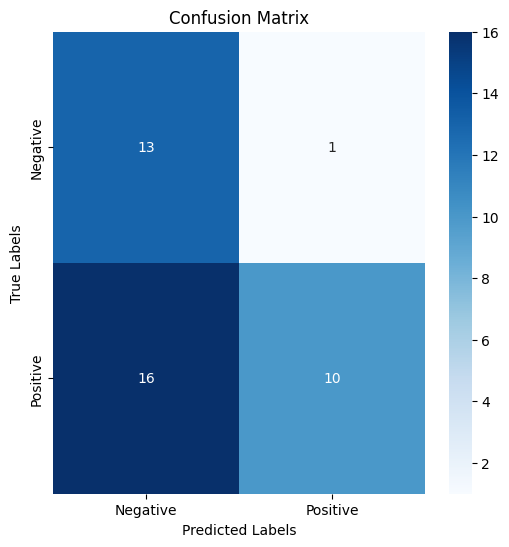

Binary Classification Accuracy: 0.575
Binary Classification F1 Score: 0.5405405405405406


In [97]:
#part 2b


# Define function for sentiment analysis with pre-trained BERT model
def bert_classifier_binary(texts, labels, test_split=0.2):
    # Initialize the sentiment-analysis pipeline
    classifier = pipeline("sentiment-analysis")

    # Split the dataset into train/test (consider adding validation if fine-tuning)
    X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=test_split, random_state=42)

    # Perform sentiment analysis
    results = classifier(X_test, truncation=True)

    # Map BERT's output to binary labels
    predictions = [0 if result['label'] == 'NEGATIVE' else 1 for result in results]

    # Calculate accuracy, confusion matrix, and F1 score
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    print(f"Binary Classification Accuracy: {accuracy}")
    print(f"Binary Classification F1 Score: {f1}")
    return accuracy, f1, cm

# Apply function to different versions of the text data for comparison
accuracy3, f1_3, cm3 = bert_classifier_binary(final_processed_text, labels)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/10
5/5 [==============================] - 22s 414ms/step - loss: 0.6914 - accuracy: 0.5125
Epoch 2/10
5/5 [==============================] - 2s 406ms/step - loss: 0.6709 - accuracy: 0.5375
Epoch 3/10
5/5 [==============================] - 2s 410ms/step - loss: 0.6549 - accuracy: 0.5875
Epoch 4/10
5/5 [==============================] - 2s 411ms/step - loss: 0.5543 - accuracy: 0.7688
Epoch 5/10
5/5 [==============================] - 2s 410ms/step - loss: 0.4650 - accuracy: 0.8687
Epoch 6/10
5/5 [==============================] - 2s 409ms/step - loss: 0.2636 - accuracy: 0.9375
Epoch 7/10
5/5 [==============================] - 2s 411ms/step - loss: 0.1054 - accuracy: 1.0000
Epoch 8/10
5/5 [==============================] - 2s 414ms/step - loss: 0.0443 - accuracy: 1.0000
Epoch 9/10
5/5 [==============================] - 2s 416ms/step - loss: 0.0221 - accuracy: 1.0000
Epoch 10/10
2/2 [==============================] - 5s 68ms/step - loss: 2.2878 - accuracy: 0.5000
Evaluation results:

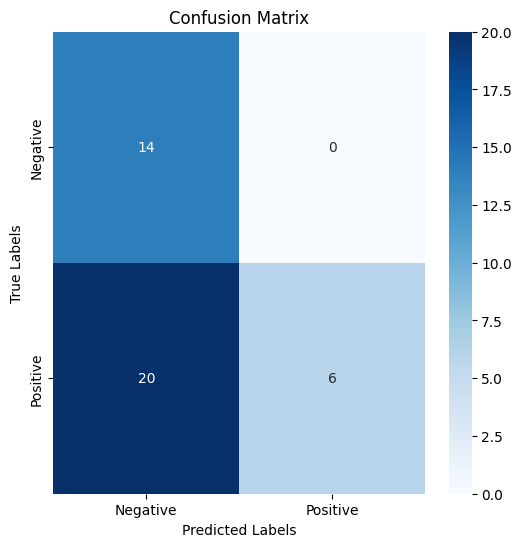

In [98]:
#part 2c


# Load the tokenizer and the DistilBERT model for TensorFlow
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Prepare dataset and labels
X = final_processed_text  # Choose your preferred preprocessed text
y = labels  # Sentiment labels: 1 for Positive, 0 for Negative

# Tokenize the data for TensorFlow
def tokenize_texts(texts, labels, max_length=128):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels
    ))
    return dataset

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize and batch the data
train_dataset = tokenize_texts(X_train, y_train).shuffle(100).batch(32)
test_dataset = tokenize_texts(X_test, y_test).batch(32)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train the model
model.fit(train_dataset, epochs=10)

# Evaluate the model
eval_results = model.evaluate(test_dataset)
print(f"Evaluation results: {eval_results}")

# Predict and evaluate with metrics
y_pred_logits = model.predict(test_dataset).logits
y_pred = np.argmax(y_pred_logits, axis=1)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

# Generate and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [99]:
#part 3

# Prepare dataset and labels (Genres)
X = final_processed_text
y = data["Genre of Movie"]

# Encode labels for multi-class classification
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.1, random_state=42)

# Define vectorizers and classifiers
vectorizers = {
    "TF-IDF": TfidfVectorizer(max_features=5000)
}

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "SVM": SVC(),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

# Initialize results dictionary
results = {}

# Experiment with different vectorizers and classifiers
for vec_name, vectorizer in vectorizers.items():
    # Vectorize the training and test data
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    for clf_name, clf in classifiers.items():
        # Train the classifier
        clf.fit(X_train_vec, y_train)

        # Make predictions
        y_pred = clf.predict(X_test_vec)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        cm = confusion_matrix(y_test, y_pred)

        # Store results
        results[f"{vec_name} + {clf_name}"] = {
            "accuracy": accuracy,
            "f1_score": f1,
            "confusion_matrix": cm
        }

# Plot confusion matrix function
def plot_confusion_matrix(cm, classes, title="Confusion Matrix"):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

# Perform multi-class classification with pre-trained BERT models
bert_models = ["bert-base-uncased", "distilbert-base-uncased"]
for model_name in bert_models:
    # Load BERT model and tokenizer for TensorFlow
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(encoder.classes_))

    # Tokenize the data
    def tokenize_texts(texts):
        return tokenizer(
            texts, max_length=128, padding=True, truncation=True, return_tensors="tf"
        )

    X_train_tokens = tokenize_texts(X_train)
    X_test_tokens = tokenize_texts(X_test)

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    # Train the model
    model.fit(X_train_tokens.data, y_train, epochs=10, batch_size=32)

    # Make predictions on the test set
    y_pred_logits = model.predict(X_test_tokens.data).logits
    y_pred = np.argmax(y_pred_logits, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)

    # Store results
    results[model_name] = {
        "accuracy": accuracy,
        "f1_score": f1,
        "confusion_matrix": cm
    }


# Summary of all results
for method, metrics in results.items():
    print(f"Method: {method}")
    print(f"Accuracy: {metrics['accuracy']}")
    print(f"F1 Score: {metrics['f1_score']}")
    print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")
    print("=" * 60)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
6/6 [==============================] - 42s 767ms/step - loss: 1.3949 - accuracy: 0.2500
Epoch 2/10
6/6 [==============================] - 5s 749ms/step - loss: 1.3059 - accuracy: 0.4500
Epoch 3/10
6/6 [==============================] - 5s 755ms/step - loss: 1.2000 - accuracy: 0.5056
Epoch 4/10
6/6 [==============================] - 5s 765ms/step - loss: 1.0029 - accuracy: 0.8222
Epoch 5/10
6/6 [==============================] - 5s 779ms/step - loss: 0.8141 - accuracy: 0.9111
Epoch 6/10
6/6 [==============================] - 5s 788ms/step - loss: 0.6402 - accuracy: 0.9556
Epoch 7/10
6/6 [==============================] - 5s 783ms/step - loss: 0.5089 - accuracy: 0.9722
Epoch 8/10
6/6 [==============================] - 5s 791ms/step - loss: 0.3964 - accuracy: 0.9944
Epoch 9/10
6/6 [==============================] - 5s 767ms/step - loss: 0.2961 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 3s 3s/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/10
6/6 [==============================] - 20s 385ms/step - loss: 1.3842 - accuracy: 0.2889
Epoch 2/10
6/6 [==============================] - 2s 372ms/step - loss: 1.3644 - accuracy: 0.3722
Epoch 3/10
6/6 [==============================] - 2s 369ms/step - loss: 1.3172 - accuracy: 0.5333
Epoch 4/10
6/6 [==============================] - 2s 370ms/step - loss: 1.2139 - accuracy: 0.6722
Epoch 5/10
6/6 [==============================] - 2s 370ms/step - loss: 1.0621 - accuracy: 0.9000
Epoch 6/10
6/6 [==============================] - 2s 375ms/step - loss: 0.8855 - accuracy: 0.9556
Epoch 7/10
6/6 [==============================] - 2s 376ms/step - loss: 0.6958 - accuracy: 0.9556
Epoch 8/10
6/6 [==============================] - 2s 374ms/step - loss: 0.5318 - accuracy: 0.9889
Epoch 9/10
6/6 [==============================] - 2s 377ms/step - loss: 0.3900 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 5s 5s/step
Method: TF-IDF + Logistic Regression
Accuracy: 1.0
F1 S

In [100]:
#part 4a

texts = final_processed_text

# Topic Modeling with LSA and LDA
def display_topics(model, feature_names, no_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}: ", " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# LSA with TF-IDF Matrix
print("\nLSA with 2 Topics:")
lsa_2 = TruncatedSVD(n_components=2, random_state=42)
lsa_2_topics = lsa_2.fit_transform(tfidf_matrix)
display_topics(lsa_2, tfidf_vectorizer.get_feature_names_out())

print("\nLSA with 4 Topics:")
lsa_4 = TruncatedSVD(n_components=4, random_state=42)
lsa_4_topics = lsa_4.fit_transform(tfidf_matrix)
display_topics(lsa_4, tfidf_vectorizer.get_feature_names_out())

# LDA with Count Vectorizer Matrix
print("\nLDA with 2 Topics:")
count_vectorizer = CountVectorizer(max_features=5000, stop_words='english')
count_matrix = count_vectorizer.fit_transform(texts).toarray()

lda_2 = LatentDirichletAllocation(n_components=2, random_state=42)
lda_2_topics = lda_2.fit_transform(count_matrix)
display_topics(lda_2, count_vectorizer.get_feature_names_out())

print("\nLDA with 4 Topics:")
lda_4 = LatentDirichletAllocation(n_components=4, random_state=42)
lda_4_topics = lda_4.fit_transform(count_matrix)
display_topics(lda_4, count_vectorizer.get_feature_names_out())

# BERTopic for Topic Modeling
print("\nBERTopic for Topic Modeling:")
topic_model = BERTopic(embedding_model="distilbert-base-uncased", nr_topics="auto")
bertopic_topics, bertopic_probs = topic_model.fit_transform(texts)

# Show BERTopic topics
print("Top topics identified by BERTopic:")
print(topic_model.get_topic_info())



LSA with 2 Topics:
Topic 1:  movie barbie horror movies films character maverick action story batman
Topic 2:  barbie gerwig gosling barbies robbie margot barbieland greta mattel baumbach

LSA with 4 Topics:
Topic 1:  movie barbie horror movies films character maverick action story batman
Topic 2:  barbie gerwig gosling barbies robbie margot barbieland greta mattel girls
Topic 3:  maverick mavericks aerial feels goose emotional action iceman barbie combat
Topic 4:  batman pattinson wayne reeves bruce gotham riddler robert alfred knight

LDA with 2 Topics:
Topic 1:  movie girls scott films character school daughter characters world comedy
Topic 2:  movie story barbie movies films horror batman action world character

LDA with 4 Topics:
Topic 1:  scott pennywise chapter black world characters losers pitch movie pilgrim
Topic 2:  batman movie kingsman action movies films characters thats oblivion world
Topic 3:  movie barbie horror movies story people world really scary house
Topic 4:  m

Top topics identified by BERTopic:
   Topic  Count                            Name  \
0     -1     41    -1_batman_movie_films_comedy   
1      0     96      0_barbie_movie_world_girls   
2      1     37  1_movie_maverick_horror_movies   
3      2     26    2_alien_pitch_black_oblivion   

                                      Representation  \
0  [batman, movie, films, comedy, jason, characte...   
1  [barbie, movie, world, girls, first, character...   
2  [movie, maverick, horror, movies, character, s...   
3  [alien, pitch, black, oblivion, planet, movie,...   

                                 Representative_Docs  
0  [movies everyone general sense specific sense ...  
1  [whatever expecting barbie promise subvert exp...  
2  [remembered iconic movie revisited today doesn...  
3  [pitch black another alien formula group peopl...  


In [101]:
topic_model.visualize_barchart()

In [102]:
#part 4b
# Define topic modeling display function
def display_topics(model, feature_names, no_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}: ", " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Loop over each text variant for topic modeling
for name, texts in texts_variants.items():
    print(f"\nTopic Modeling for {name}...")

    # TF-IDF Vectorization for LSA
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

    # LSA (Latent Semantic Analysis)
    print(f"\nLSA Topics for {name}:")
    lsa_model = TruncatedSVD(n_components=4, random_state=42)  # Using 4 topics
    lsa_topics = lsa_model.fit_transform(tfidf_matrix)
    display_topics(lsa_model, tfidf_vectorizer.get_feature_names_out())

    # LDA (Latent Dirichlet Allocation)
    print(f"\nLDA Topics for {name}:")
    count_vectorizer = CountVectorizer(max_features=5000, stop_words='english')
    count_matrix = count_vectorizer.fit_transform(texts)
    lda_model = LatentDirichletAllocation(n_components=4, random_state=42)  # Using 4 topics
    lda_topics = lda_model.fit_transform(count_matrix)
    display_topics(lda_model, count_vectorizer.get_feature_names_out())

    # BERTopic
    print(f"\nBERTopic Topics for {name}:")
    topic_model = BERTopic(embedding_model="distilbert-base-uncased", nr_topics="auto")  # Replace with preferred embedding model
    bertopic_topics, bertopic_probs = topic_model.fit_transform(texts)

    # Show BERTopic topics
    topic_info = topic_model.get_topic_info()
    print(topic_info.head(10))  # Display the top 10 topics


Topic Modeling for final_processed_text...

LSA Topics for final_processed_text:
Topic 1:  movie barbie horror movies films character maverick action story batman
Topic 2:  barbie gerwig gosling barbies robbie margot barbieland greta mattel girls
Topic 3:  maverick mavericks aerial feels goose emotional action iceman barbie combat
Topic 4:  batman pattinson wayne reeves bruce gotham riddler robert alfred knight

LDA Topics for final_processed_text:
Topic 1:  scott pennywise chapter black world characters losers pitch movie pilgrim
Topic 2:  batman movie kingsman action movies films characters thats oblivion world
Topic 3:  movie barbie horror movies story people world really scary house
Topic 4:  movie films action girls character maverick doesnt school scenes story

BERTopic Topics for final_processed_text:


   Topic  Count                              Name  \
0     -1     95  -1_batman_movie_films_characters   
1      0     40    0_movie_maverick_horror_movies   
2      1     22     1_scott_world_pilgrim_preston   
3      2     17     2_oblivion_earth_planet_alien   
4      3     16      3_barbie_girls_gerwig_robbie   
5      4     10  4_conjuring_horror_warrens_james   

                                      Representation  \
0  [batman, movie, films, characters, years, stor...   
1  [movie, maverick, horror, movies, scenes, char...   
2  [scott, world, pilgrim, preston, ramona, wrigh...   
3  [oblivion, earth, planet, alien, black, pitch,...   
4  [barbie, girls, gerwig, robbie, margot, barbie...   
5  [conjuring, horror, warrens, james, franchise,...   

                                 Representative_Docs  
0  [difficult making movie others entire based fi...  
1  [remembered iconic movie revisited today doesn...  
2  [scott pilgrim world essentially story piled s...  
3  [since quest

In [103]:
topic_model.visualize_barchart()

In [104]:
topic_model.visualize_heatmap()